In [1]:
"""
This notebook contains a working example show usage of the new
image classifier based saliency map API for choosing to use 
a occlusion based saliency map algorithm.

Reference for implementation: Zeiler MD, Fergus R. Visualizing 
and understanding convolutional networks. InEuropean conference
on computer vision 2014 Sep 6 (pp. 818-833). Springer, Cham.

"""
from xaitk_saliency.interfaces.perturb_image import PerturbImage
from xaitk_saliency.interfaces.vis_sal_classifier import ImageClassifierSaliencyMapGenerator
from smqtk_core.configuration import from_config_dict

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import torchvision.models as models
from sklearn.linear_model import LogisticRegression
import torch

positive_image_path = 'dog.jpg'
negeative_image_path = 'horse.jpeg'
test_image = 'catdog.png'

# Declaring xaitk implementation instantiations 
sliding_window_cfg = {
    "type": "xaitk_saliency.impls.saliency.sliding_window.SlidingWindow",
    "xaitk_saliency.impls.saliency.sliding_window.SlidingWindow": {
    "window_size": 25,
    "stride": 5,
    },
  }
fsal_cfg = {
    "type": "xaitk_saliency.impls.saliency.fsal.Fsal",
    "xaitk_saliency.impls.saliency.fsal.Fsal": {
    },
  }

# Creating xaitk objects for sliding window and classifier based Fsal approach. 
slid_algo = from_config_dict(sliding_window_cfg, PerturbImage.get_impls())
fsal_alg = from_config_dict(fsal_cfg, ImageClassifierSaliencyMapGenerator.get_impls())

# Creating an example deep feature extractor to describe images
nativemodel = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*(list(nativemodel.children())[:-1]))
model = model.eval()
model = model.cuda()

/home/local/KHQ/bhavan.vasu/anaconda3/envs/xaitk_saliency/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
Failed to import caffe module: No module named 'caffe'


In [2]:
# Input image loader to match feature extractor expectation
imsize = 224
loader = transforms.Compose([transforms.Resize((imsize)), transforms.ToTensor()])

def image_loader(image_name):
    try:
        image = Image.open(image_name)
    except AttributeError:
        # If Image already open
        image = image_name
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    return image.cuda().unsqueeze(0)

def compute_feature_descr(model, image_tensor):
    featureVec = model(image_tensor)
    return featureVec.cpu().detach().numpy().squeeze()

# Using example training examples for binary classification of dogs vs not
# Compute positive and negative feature vectors
pos_feat = compute_feature_descr(model, image_loader(positive_image_path))
neg_feat = compute_feature_descr(model, image_loader(negeative_image_path))

# Test image containing both cat and dog.
test_img = Image.open(test_image).resize((imsize, imsize))
# Compute test image feature vector
test_feat = compute_feature_descr(model, image_loader(test_image))

# Use created sling window based perturbation algorithm to perturb test image
pert_img, pertmask = slid_algo.perturb(test_img)

# Compute feature vector on perturbed version of the test image
ptrbed_feat = [compute_feature_descr(model, image_loader(ptrbed)) for ptrbed in pert_img]

In [3]:
# Train a simple logistic regression to predict logit scores
clf = LogisticRegression(random_state=0, tol=1e-6)
# Training the classifier with image containing dog as positive 
# and the image with horse is marked a negative
train_X = [pos_feat, neg_feat]
train_Y = [1, 0]
clf = clf.fit(train_X, train_Y)

# Compute classifier confidence on perturbed version of the test image
prtbd_conf = clf.predict_proba(ptrbed_feat)

dims = len(test_feat)
org_conf = clf.predict_proba(test_feat.reshape(1, dims))
# Generating final saliency map for both positive and negative classes
final_saliency_map = fsal_alg.generate(org_conf[0], prtbd_conf, pertmask[:,:,:,0])


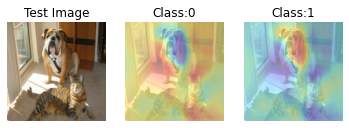

In [4]:
sub_plot_ind = len(final_saliency_map) + 1

# Visualizing Saliency maps for both classes
plt.figure()
plt.subplot(1, sub_plot_ind, 1)
plt.imshow(test_img)
plt.axis('off')
plt.title('Test Image')

for i, class_sal_map in enumerate(final_saliency_map):
    plt.subplot(1, sub_plot_ind, i+2)
    plt.imshow(test_img, alpha=0.5)
    plt.imshow(class_sal_map, cmap='jet', alpha=0.3)
    plt.title('Class:{}'.format(i))
    plt.axis('off')
    
plt.show()